<a href="https://colab.research.google.com/github/dqminhv/fraudulent-job-posting-detection-with-NLP/blob/main/notebook/data-preprocessing-and-modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocessing

## Import required packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, precision_score, recall_score, roc_curve, auc, f1_score
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

#Import classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

In [2]:
job_posting_us_df = pd.read_csv('https://raw.githubusercontent.com/dqminhv/fraudulent-job-posting-detection-with-NLP/main/Data/job-posting-us.csv')

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Create a text cleaning function

In [4]:
#Create a function to clean the text feature
stop=set(stopwords.words("english"))

def clean(text):
    text=text.lower()
    obj=re.compile(r"<.*?>")                     #removing html tags
    text=obj.sub(r" ",text)
    obj=re.compile(r"https://\S+|http://\S+")    #removing url
    text=obj.sub(r" ",text)
    obj=re.compile(r"[^\w\s]")                   #removing punctuations
    text=obj.sub(r" ",text)
    obj=re.compile(r"\d{1,}")                    #removing digits
    text=obj.sub(r" ",text)
    obj=re.compile(r"_+")                        #removing underscore
    text=obj.sub(r" ",text)
    obj=re.compile(r"\s\w\s")                    #removing single character
    text=obj.sub(r" ",text)
    obj=re.compile(r"\s{2,}")                    #removing multiple spaces
    text=obj.sub(r" ",text)
    lemmatizer = WordNetLemmatizer()
    text=[lemmatizer.lemmatize(word) for word in text.split() if word not in stop]
    return " ".join(text)

## Turning int variable to text

In [5]:
job_posting_us_df.loc[job_posting_us_df.telecommuting == 1, 'telecommuting'] = 'telecommuting'
job_posting_us_df.loc[job_posting_us_df.telecommuting == 0, 'telecommuting'] = 'no-telecommuting'

job_posting_us_df.loc[job_posting_us_df.has_company_logo == 1, 'has_company_logo'] = 'has-logo'
job_posting_us_df.loc[job_posting_us_df.has_company_logo == 0, 'has_company_logo'] = 'no-logo'

job_posting_us_df.loc[job_posting_us_df.has_questions == 1, 'has_questions'] = 'has-questions'
job_posting_us_df.loc[job_posting_us_df.has_questions == 0, 'has_questions'] = 'no-question'

## Create a text feature by combining all the columns

In [6]:
#Combine all features into one column
job_posting_us_df["text"]=""
for col in job_posting_us_df.drop('fraudulent', axis=1).columns:
    job_posting_us_df["text"]=job_posting_us_df["text"]+" "+job_posting_us_df[col]

In [7]:
job_posting_us_df['text'].apply(clean)

0       marketing intern u ny new york marketing speci...
1       account executive washington dc u dc washingto...
2       bill review manager u fl fort worth specified ...
3       customer service associate part time u az phoe...
4       asp net developer job opportunity united state...
                              ...                        
6747    post production editor u ia west de moines spe...
6748    senior financial analyst retail u ca gardena s...
6749    product manager u ca san francisco product dev...
6750    javascript developer u specified specified sr ...
6751    payroll accountant u pa philadelphia accountin...
Name: text, Length: 6752, dtype: object

# Modeling

**1. Models**



Given the imbalanced nature of the dataset and the task of classifying fraudulent job postings based on job descriptions, several classification algorithms can be considered. However, algorithms that handle class imbalance well and are robust to noisy data are typically preferred. Here are some algorithms that you may want to consider:

- **Random Forest**: Random Forest is an ensemble learning algorithm that works well with imbalanced datasets. It builds multiple decision trees and combines their predictions to improve accuracy.

- **Gradient Boosting Machines (GBM)**: GBM algorithms like XGBoost, LightGBM, and CatBoost are also effective for imbalanced classification tasks. They sequentially build multiple weak learners to minimize a loss function, which often leads to better performance on imbalanced datasets.

- **Support Vector Machines (SVM)**: SVM is a powerful algorithm for binary classification tasks. By adjusting the hyperparameters, such as the regularization parameter (C) and the kernel function, SVM can be effective for imbalanced data.

- **Logistic Regression**: Despite its simplicity, logistic regression can perform well on imbalanced datasets, especially when combined with techniques like class weighting or penalization.

- **AdaBoost**: AdaBoost is an ensemble learning algorithm that combines multiple weak classifiers to create a strong classifier. It is known to perform well on imbalanced datasets.

- **Neural Networks**: Deep learning models, such as neural networks, can also be effective for imbalanced classification tasks, especially when dealing with large datasets. Architectures like Convolutional Neural Networks (CNNs) or Recurrent Neural Networks (RNNs) can capture complex patterns in text data.

- **Naive Bayes**: Despite its simplicity and assumption of feature independence, Naive Bayes can perform surprisingly well on text classification tasks, including imbalanced datasets.

**2. Metrics**

For a fraud detection problem with an imbalanced dataset where the non-fraudulent class comprises 90% of the dataset, we use F1 score to evaluate the performance of the model. We want to maximize the True Positive Rate, which means we want to catch all the fraudulent job postings, but we also want to minimize the false positive rate, which means we do not want to flag to many legit job posting as fraudulent.

**F1 Score**: The F1 score is the harmonic mean of precision and recall. It provides a balance between precision and recall and is useful when there is an imbalance between the classes in the dataset. The F1 score is calculated as 2 * (precision * recall) / (precision + recall).

## Train/Test Split

In [8]:
X = job_posting_us_df['text']
y = job_posting_us_df['fraudulent']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Vectorizing text data

In [10]:
#Parameters
stop_words = 'english'
min_df = .2
max_df = .7
ngram_range=(1, 1)

In [11]:
#Using TfidfVectorizer
tfidf_vect = TfidfVectorizer(stop_words=stop_words, max_df=max_df, min_df=min_df, ngram_range=ngram_range)

## Defining classifiers

In [12]:
# Define the classifiers
classifiers = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Random Forest Classifier": RandomForestClassifier(),
    "Support Vector Classifier": SVC(probability=True),
    'Gradient Boosting Classifier' : GradientBoostingClassifier(),
    'Logistic Regression Classifier': LogisticRegression(penalty='l2', solver='liblinear'),
    'Ada Boost Classifier': AdaBoostClassifier(),
    'Neural Network Classifier': MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)
}

## Create pipeline

In [13]:
# Create the pipeline for each classifier
pipelines = {}
for classifier_name, classifier in classifiers.items():
    pipelines[classifier_name] = Pipeline([
        ('vectorizer', tfidf_vect),
        ('classifier', classifier)
    ])

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier: Multinomial Naive Bayes
Recall: 0.0
Precision: 0.0
F1 Score: 0.0


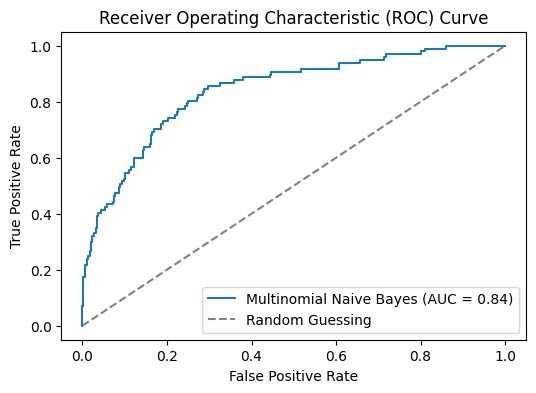


Classifier: Random Forest Classifier
Recall: 0.38144329896907214
Precision: 1.0
F1 Score: 0.5522388059701492


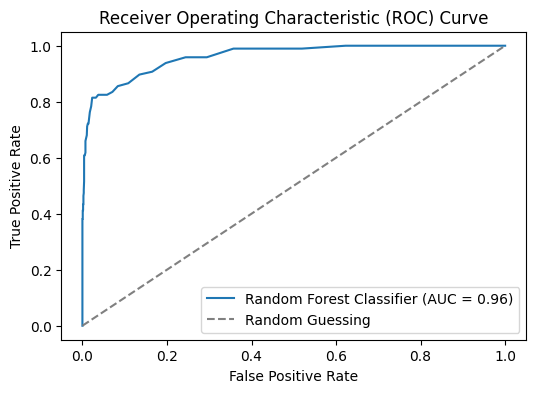


Classifier: Support Vector Classifier
Recall: 0.5051546391752577
Precision: 0.98
F1 Score: 0.6666666666666666


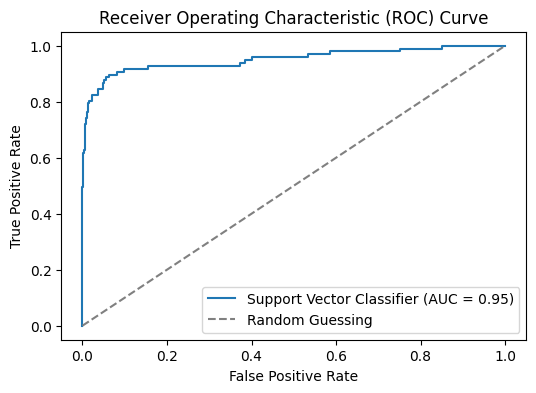


Classifier: Gradient Boosting Classifier
Recall: 0.32989690721649484
Precision: 0.9142857142857143
F1 Score: 0.4848484848484848


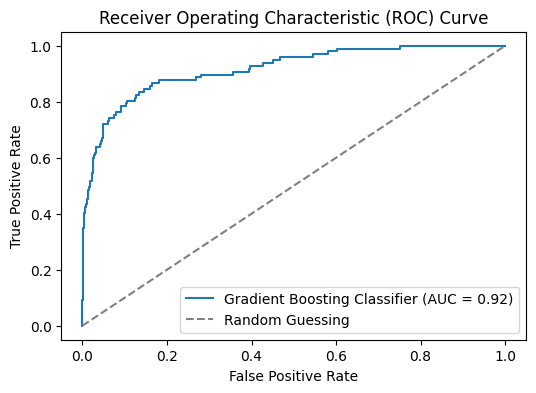


Classifier: Logistic Regression Classifier
Recall: 0.15463917525773196
Precision: 0.75
F1 Score: 0.25641025641025644


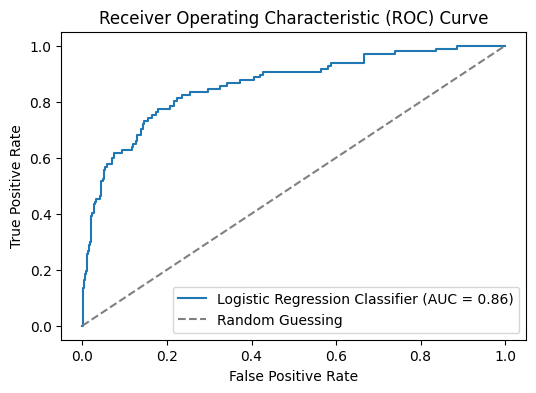


Classifier: Ada Boost Classifier
Recall: 0.31958762886597936
Precision: 0.5849056603773585
F1 Score: 0.4133333333333333


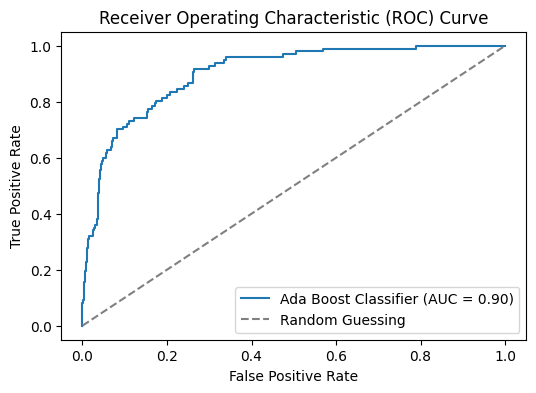


Classifier: Neural Network Classifier
Recall: 0.7010309278350515
Precision: 0.8607594936708861
F1 Score: 0.7727272727272727


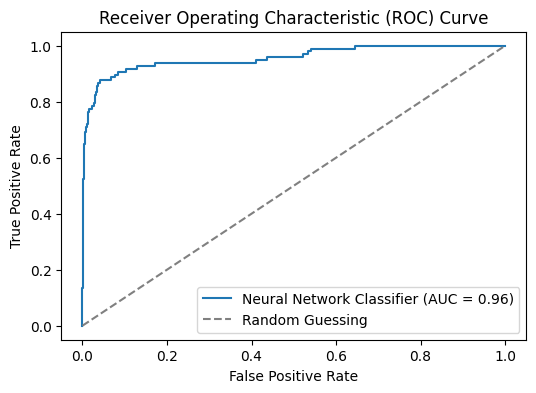

In [14]:
for classifier_name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    print(f"Classifier: {classifier_name}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"F1 Score: {f1}")

    # Plot ROC curves for each classifier
    plt.figure(figsize=(6, 4))
    # Get predicted probabilities
    y_score = pipeline.predict_proba(X_test)[:, 1]

    # Calculate fpr and tpr
    fpr, tpr, _ = roc_curve(y_test, y_score)

    # Calculate AUC
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{classifier_name} (AUC = {roc_auc:.2f})')

    # Plot ROC curve for random guessing
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Guessing')

    # Set labels and title
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')

    # Show plot
    plt.show()
    print()

## Model selection and Hyper-paramerters tuning

The Neural Network Classifier yield the highest F1 score. Thus, we will select this model and perform hyper-parameters tuning.

In [16]:
from sklearn.model_selection import GridSearchCV

# Define the pipeline
pipeline = Pipeline([
    ('vectorizer', tfidf_vect),
    ('clf', MLPClassifier(max_iter=1000))
])

# Define hyperparameters and their ranges
parameters = {
    'clf__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'clf__activation': ['logistic', 'relu'],
    'clf__alpha': [0.0001, 0.001, 0.01],
    'clf__learning_rate': ['constant', 'adaptive'],
}

# Define the GridSearchCV object
grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring='f1', verbose=1)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found:")
print(grid_search.best_params_)

# Evaluate the best model on the test set
y_pred = grid_search.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters found:
{'clf__activation': 'relu', 'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate': 'constant'}
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1254
           1       0.85      0.70      0.77        97

    accuracy                           0.97      1351
   macro avg       0.91      0.85      0.88      1351
weighted avg       0.97      0.97      0.97      1351



## Export Best Model

In [17]:
import pickle

# Save the model to a file
with open('model.pkl', 'wb') as file:
    pickle.dump(grid_search, file)